In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/vmeshchaninov/DiffusionTextGeneration/")

In [3]:
import torch
import numpy as np
import ml_collections
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
from diffusion_holder import DiffusionRunner
from transformers import BertConfig, BertTokenizerFast

from data.create_dataset import create_wikipedia_dataset, create_rocstory_dataset, create_glue_unsupervised_dataset
from data.preprocessing import text_preprocessor, unsupervised_preprocessor, supervised_preprocessor
from utils.util import dict_to_tensors, masked_mean, masked_std, set_seed, dict_to_cuda
from estimation_utils.util import clear_text, compute_metric
from estimation_utils.metrics import BloomMetric

In [4]:
def create_config():
    config = ml_collections.ConfigDict()

    training = config.training = ml_collections.ConfigDict()
    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints'
    checkpoints_prefix = ""
    
    sde = config.sde = ml_collections.ConfigDict()
    sde.typename = 'vp-sde'
    sde.solver = 'euler'
    sde.N = 2000
    sde.beta_min = 0.1
    sde.beta_max = 20
    sde.ode_sampling = False

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "encodings"
    model.dif_enc_type = "base"
    model.prediction = "x_0"
    model.dataset = "rocstory"

    data = config.data = ml_collections.ConfigDict()
    data.config_path = "/home/vmeshchaninov/DiffusionTextGeneration/data/config.json"
    data.max_sequence_len = 32

    config.device = 'cuda:0'
    config.ddp = False
    config.seed = 0
    config.bert_config = None
    return config

In [5]:
config = create_config()
config.checkpoints_prefix = "rocstory--encodings-prediction=x_0-loss=L_x_0-enc=base-bert=base-kl_cf=0.0-seq_len=32-clipgrad=0.2-lr=0.0002-min_lr=0.0002-new_net_v1.3_time_norm_1000000_"
config.lin_input = True
config.bert_config = BertConfig.from_pretrained("bert-base-uncased")

seed = config.seed
set_seed(seed)

diffusion_old = DiffusionRunner(config, latent_mode="encodings", eval=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
config = create_config()
config.checkpoints_prefix = "rocstory--encodings-prediction=x_0-loss=L_x_0-enc=base-bert=base-kl_cf=0.0-seq_len=32-clipgrad=0.2-lr=0.0002-min_lr=0.0002-new_net_v1.3.4-woinputproj_1000000_"
config.lin_input = False
config.bert_config = BertConfig.from_pretrained("bert-base-uncased")

seed = config.seed
set_seed(seed)

diffusion_new = DiffusionRunner(config, latent_mode="encodings", eval=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
metric_bloom_fn = BloomMetric(device=f"cuda:0")

In [11]:
max_sequence_len = 32
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset_roc = create_rocstory_dataset(split="validation", tokenizer=tokenizer, max_sequence_len=max_sequence_len)

In [12]:
batch_size = 32
loader = DataLoader(
            dataset_roc,
            batch_size=batch_size,
            num_workers=1,
            shuffle=False,
        )


for X in loader:
    break
X = dict_to_cuda(X)

In [14]:
embs = diffusion_old.sampler_emb({key:X[key].cuda() for key in ["input_ids", "attention_mask"]})
mask = X["attention_mask"]
torch.mean(masked_mean(embs, mask)), torch.mean(masked_std(embs, mask))

(tensor(0.0001, device='cuda:0'), tensor(1.0043, device='cuda:0'))

## Эксперимент 1

In [8]:
@torch.no_grad()
def integrate_euler(diffusion, time_range, x_t):
    for t in tqdm(time_range):
        vec_t = t * torch.ones(batch_size, device="cuda:0")
        x_t = diffusion.diff_eq_solver.step(model=diffusion.score_estimator, x_t=x_t, t=vec_t)["x"]
    return x_t

In [9]:
eps_t = 1. / diffusion_old.diff_eq_solver.sde.N
timesteps = torch.linspace(diffusion_old.sde.T, eps_t, diffusion_old.sde.N, device=diffusion_old.device)

In [54]:
set_seed(seed)

batch_size = 32
shape = (
            batch_size,
            diffusion_old.config.data.max_sequence_len,
            diffusion_old.encoder.config.hidden_size
        )
x_t = diffusion_old.sde.prior_sampling(shape).to(diffusion_old.device)

In [61]:
n = 0
x_t = integrate_euler(diffusion_old, timesteps[:n], x_t)
x = integrate_euler(diffusion_new, timesteps[n:], x_t)

0it [00:00, ?it/s]
 23%|██▎       | 463/2000 [00:07<00:24, 61.79it/s]


KeyboardInterrupt: 

In [56]:
output = diffusion_old.pred_logits(x, None)
tokens = output.argmax(dim=-1)
text = diffusion_old.tokenizer.batch_decode(tokens)

In [57]:
text = clear_text(text)
compute_metric(metric_bloom_fn, text)

metric: bigscience/bloom-7b1, 3.7685: 100%|██████████| 32/32 [00:01<00:00, 19.18it/s]


3.768486860084922

In [10]:
dual_se_metric = dict()

In [11]:
for n in range(0, 801, 100):
    set_seed(seed)

    batch_size = 256
    shape = (
                batch_size,
                diffusion_old.config.data.max_sequence_len,
                diffusion_old.encoder.config.hidden_size
            )
    x_t = diffusion_old.sde.prior_sampling(shape).to(diffusion_old.device)
    
    x_t = integrate_euler(diffusion_new, timesteps[:n], x_t) # Important lines
    x_t = integrate_euler(diffusion_old, timesteps[n:800], x_t) # Important lines
    x = integrate_euler(diffusion_new, timesteps[800:], x_t)
    
    output = diffusion_old.pred_logits(x, None)
    tokens = output.argmax(dim=-1)
    text = diffusion_old.tokenizer.batch_decode(tokens)
    
    text = clear_text(text)
    dual_se_metric[n] = compute_metric(metric_bloom_fn, text)

0it [00:00, ?it/s]
100%|██████████| 800/800 [01:25<00:00,  9.32it/s]
0it [00:00, ?it/s]
metric: bigscience/bloom-7b1, 3.9142: 100%|██████████| 256/256 [00:13<00:00, 19.01it/s]


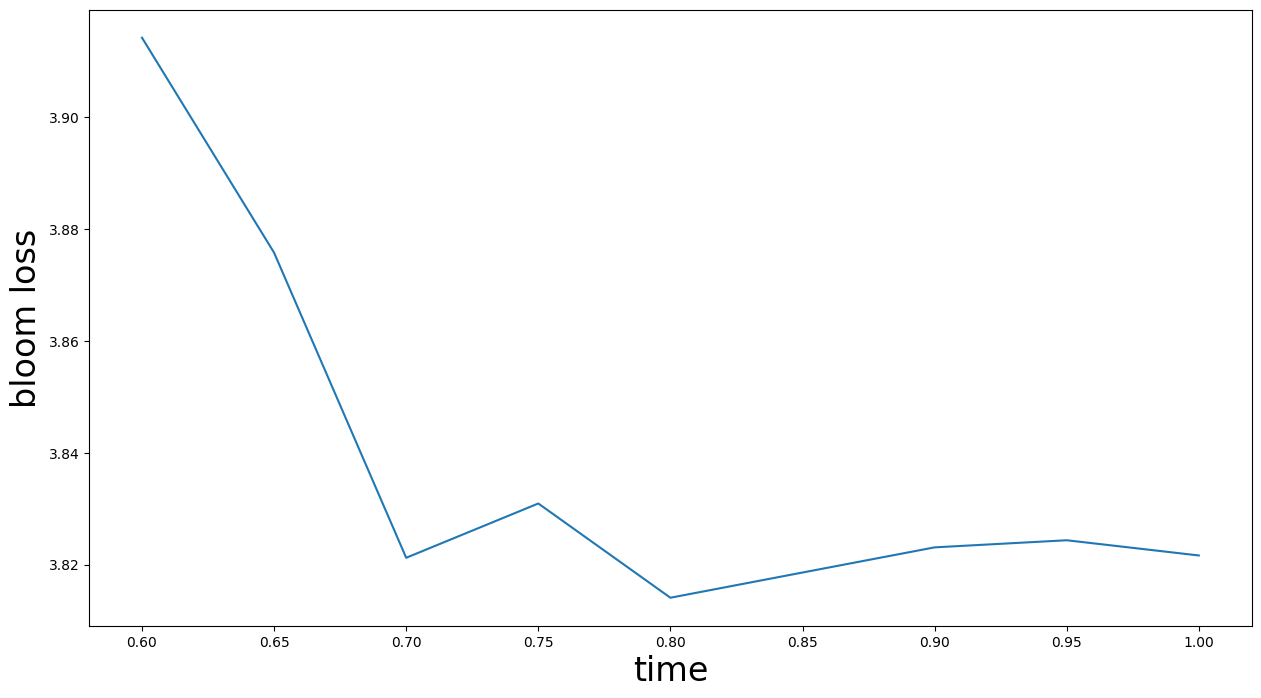

In [12]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('bloom loss', fontsize=24)
#plt.title("norm x_t, dim=768", fontsize=24)

x = sorted(list(dual_se_metric.keys()))
y = [dual_se_metric[i] for i in x]
x = [(2000 - i) / 2000 for i in x]

plt.plot(x, y)

In [13]:
n = 600
set_seed(seed)

batch_size = 256 * 8
shape = (
            batch_size,
            diffusion_old.config.data.max_sequence_len,
            diffusion_old.encoder.config.hidden_size
        )
x_t = diffusion_old.sde.prior_sampling(shape).to(diffusion_old.device)

x_t = integrate_euler(diffusion_new, timesteps[:n], x_t) # Important lines
x_t = integrate_euler(diffusion_old, timesteps[n:800], x_t) # Important lines
x = integrate_euler(diffusion_new, timesteps[800:], x_t)

output = diffusion_old.pred_logits(x, None)
tokens = output.argmax(dim=-1)
text = diffusion_old.tokenizer.batch_decode(tokens)

text = clear_text(text)
compute_metric(metric_bloom_fn, text)

metric: bigscience/bloom-7b1, 3.8317: 100%|██████████| 2048/2048 [01:47<00:00, 19.10it/s]


3.831671891282473

### Построим график реконструкции кросс энтропии текста

In [14]:
max_sequence_len = 32
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset_roc = create_rocstory_dataset(split="validation", tokenizer=tokenizer, max_sequence_len=max_sequence_len)

In [15]:
batch_size = 256
loader = DataLoader(
            dataset_roc,
            batch_size=batch_size,
            num_workers=1,
            shuffle=False,
        )


for X in loader:
    break
X = dict_to_cuda(X)

In [16]:
embs = diffusion_old.sampler_emb({key:X[key].cuda() for key in ["input_ids", "attention_mask"]})
mask = X["attention_mask"]
torch.mean(masked_mean(embs, mask)), torch.mean(masked_std(embs, mask))

(tensor(-0.0003, device='cuda:0'), tensor(1.0097, device='cuda:0'))

In [21]:
set_seed(seed)

with torch.no_grad():    
    losses_x_0_old = []
    ce_s_text_old = []
    
    for t in tqdm(range(0, diffusion_old.diff_eq_solver.sde.N)):
        t = t * 1. / diffusion_old.diff_eq_solver.sde.N
        vec_t = t * torch.ones(batch_size, device="cuda:0")
        marg_forward = diffusion_old.sde.marginal_forward(embs, vec_t)
        x_t = marg_forward['x_t']
        noise = marg_forward['noise']
        
        scores = diffusion_old.sde.calc_score(diffusion_old.score_estimator, x_t, vec_t)
        x_0 = scores.pop("x_0")
        
        loss = diffusion_old.mse_loss(x_0, embs, mask)
        losses_x_0_old.append(loss.item())
        
        output_t = diffusion_old.pred_logits(x_0, None)
        
        ce_loss = diffusion_old.recon_loss(output_t, X["input_ids"], mask)
        ce_s_text_old.append(ce_loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]/home/vmeshchaninov/anaconda3/envs/env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 2000/2000 [04:27<00:00,  7.47it/s]


In [22]:
set_seed(seed)

with torch.no_grad():    
    losses_x_0_new = []
    ce_s_text_new = []
    
    for t in tqdm(range(0, diffusion_new.diff_eq_solver.sde.N)):
        t = t * 1. / diffusion_new.diff_eq_solver.sde.N
        vec_t = t * torch.ones(batch_size, device="cuda:0")
        marg_forward = diffusion_new.sde.marginal_forward(embs, vec_t)
        x_t = marg_forward['x_t']
        noise = marg_forward['noise']
        
        scores = diffusion_new.sde.calc_score(diffusion_new.score_estimator, x_t, vec_t)
        x_0 = scores.pop("x_0")
        
        loss = diffusion_new.mse_loss(x_0, embs, mask)
        losses_x_0_new.append(loss.item())
        
        output_t = diffusion_new.pred_logits(x_0, None)
        
        ce_loss = diffusion_new.recon_loss(output_t, X["input_ids"], mask)
        ce_s_text_new.append(ce_loss.item())

100%|██████████| 2000/2000 [04:25<00:00,  7.54it/s]


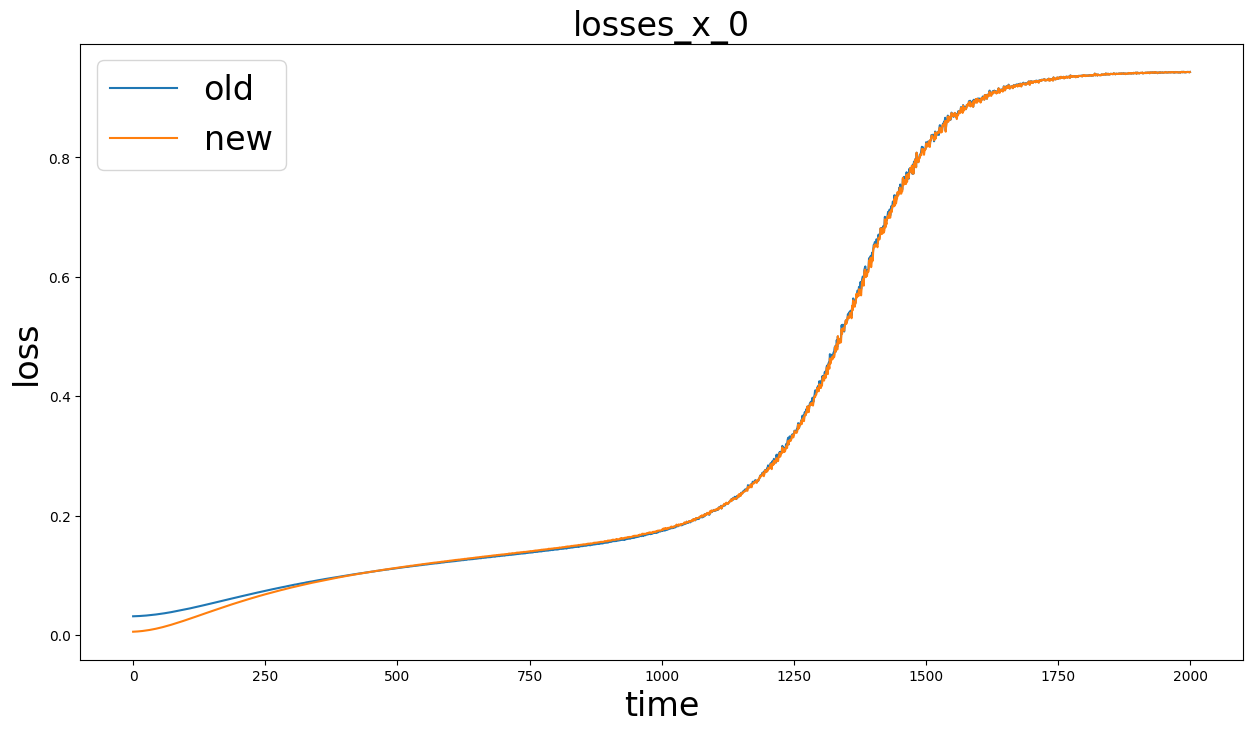

In [23]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("losses_x_0", fontsize=24)

plt.plot(losses_x_0_old, label="old")
plt.plot(losses_x_0_new, label="new")

plt.legend(fontsize=24)
plt.show()

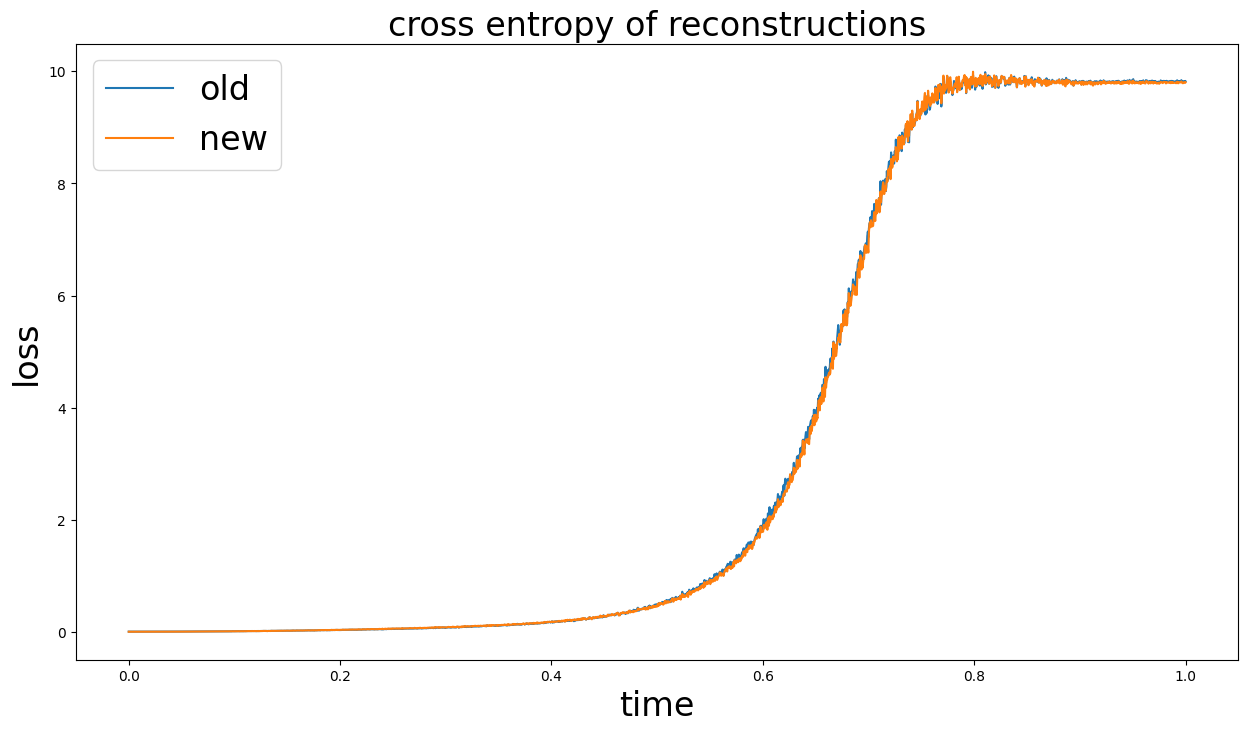

In [32]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("cross entropy of reconstructions", fontsize=24)

plt.plot(np.linspace(0, 1, 2000), ce_s_text_old, label="old")
plt.plot(np.linspace(0, 1, 2000), ce_s_text_new, label="new")

plt.legend(fontsize=24)
plt.show()

In [40]:
alphas = []
stds = []
for t in np.linspace(0, 1, 2000):
    vec_t = t * torch.ones(batch_size, device="cuda:0")
    alphas.append(diffusion_new.sde.marginal_params_scalar(vec_t)['alpha'][0].item())
    stds.append(diffusion_new.sde.marginal_params_scalar(vec_t)['std'][0].item())

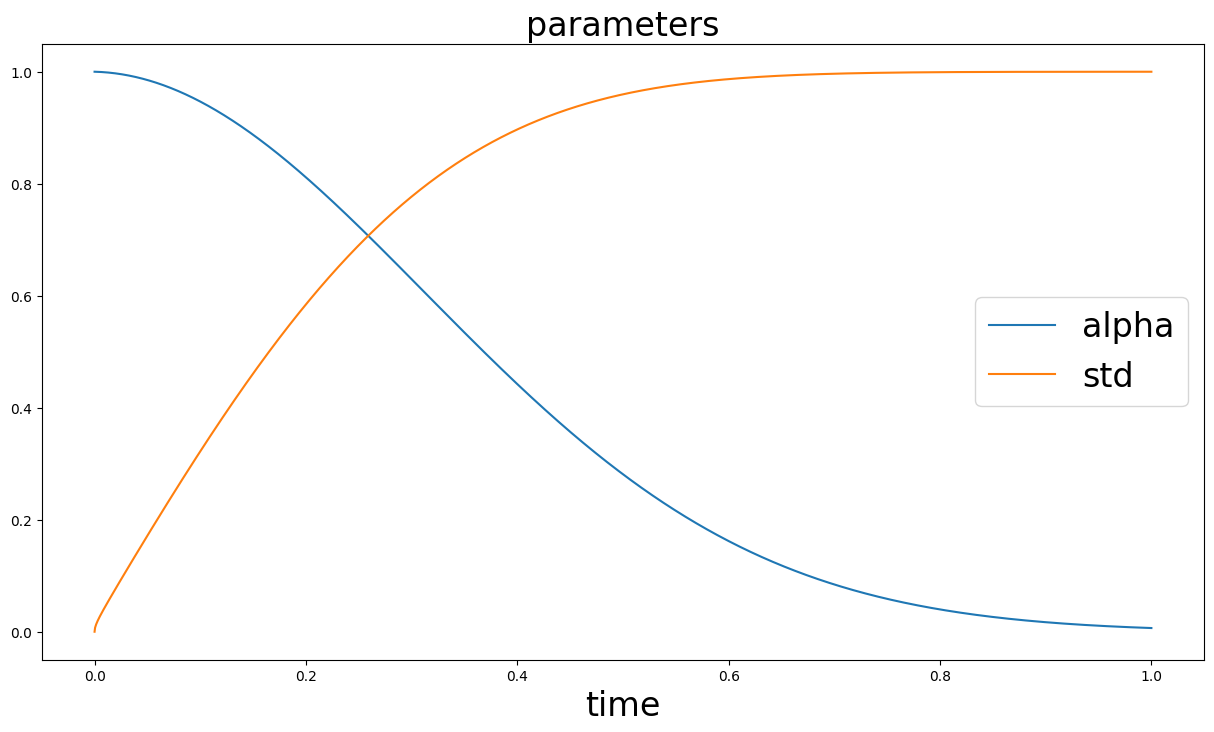

In [41]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.title("parameters", fontsize=24)

plt.plot(np.linspace(0, 1, 2000), alphas, label="alpha")
plt.plot(np.linspace(0, 1, 2000), stds, label="std")

plt.legend(fontsize=24)
plt.show()